# Inference Demo

Load a trained model, run predictions on sampled images, and visualise the confidences. Update the paths below to match the artifacts you downloaded from SageMaker.

In [1]:
from pathlib import Path
import sys

PROJECT_ROOT = None
for candidate in [Path.cwd()] + list(Path.cwd().parents):
    if (candidate / 'src').exists():
        PROJECT_ROOT = candidate
        break

if PROJECT_ROOT is None:
    raise RuntimeError('Could not locate project root containing src/')

SRC_PATH = PROJECT_ROOT / 'src'
if str(SRC_PATH) not in sys.path:
    sys.path.append(str(SRC_PATH))

print(f'Project root: {PROJECT_ROOT}')

Project root: /workspaces/pp_defectvision


In [2]:
import matplotlib.pyplot as plt
from PIL import Image

from inference import load_session

# MODEL_PATH = PROJECT_ROOT / 'models' / 'model.pth'
MODEL_PATH = Path('/workspaces/pp_defectvision/models/defectvision-train-20251012-195857/output/model.pth')
# CLASS_NAMES_PATH = MODEL_PATH.with_name('class_names.json')
CLASS_NAMES_PATH = Path('/workspaces/pp_defectvision/models/defectvision-train-20251012-195857/output/class_names.json')
IMAGE_DIR = PROJECT_ROOT / 'src' / 'inference' / 'test_images'

print(f'Model path: {MODEL_PATH}')
print(f'Class names: {CLASS_NAMES_PATH}')
print(f'Image directory: {IMAGE_DIR}')

Model path: /workspaces/pp_defectvision/models/defectvision-train-20251012-195857/output/model.pth
Class names: /workspaces/pp_defectvision/models/defectvision-train-20251012-195857/output/class_names.json
Image directory: /workspaces/pp_defectvision/src/inference/test_images


In [3]:
session = load_session(MODEL_PATH, class_names_path=CLASS_NAMES_PATH, model_name='resnet18')
print(f'Loaded model with {len(session.class_names)} classes')

Loaded model with 15 classes


In [4]:
def extract_ground_truth(image_path):
    name = image_path.name

    def double_positions(text):
        positions = []
        i = 0
        while i < len(text) - 1:
            if text[i:i+2] == '__' and (i + 2 >= len(text) or text[i+2] != '_') and (i == 0 or text[i-1] != '_'):
                positions.append(i)
                i += 2
            else:
                i += 1
        return positions

    positions = double_positions(name)
    if len(positions) >= 2:
        return name[: positions[1] + 2]
    if positions:
        return name
    return image_path.parent.name


def show_prediction(image_path, topk=5):
    ground_truth = extract_ground_truth(image_path)
    predictions = session.predict_batch([image_path], topk=topk)
    pred = predictions[0]

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    img = Image.open(pred.image_path)
    axes[0].imshow(img)
    axes[0].set_title(f'GT: {ground_truth}\nPred: {pred.label} (conf {pred.confidence:.2%})')
    axes[0].axis('off')

    labels = pred.topk_labels[:topk][::-1]
    confs = pred.topk_confidences[:topk][::-1]
    axes[1].barh(labels, confs, color='tab:blue')
    axes[1].set_xlim(0, 1)
    axes[1].set_xlabel('Confidence')
    axes[1].set_title('Top predictions')
    plt.tight_layout()
    plt.show()

    pred.ground_truth = ground_truth
    return pred

In [5]:
image_candidates = sorted(IMAGE_DIR.glob('*.jpg')) + \
    sorted(IMAGE_DIR.glob('*.JPG')) + \
    sorted(IMAGE_DIR.glob('*.png'))
print(f'Found {len(image_candidates)} images')

Found 45 images


In [6]:
image_candidates = sorted(IMAGE_DIR.glob('*.jpg')) + \
    sorted(IMAGE_DIR.glob('*.JPG')) + \
    sorted(IMAGE_DIR.glob('*.png'))
print(f'Found {len(image_candidates)} images')
if len(image_candidates) == 0:
    raise ValueError('No images found in IMAGE_DIR')

Found 45 images


=== Pepper__bell___Bacterial_spot__01940b6d-7dea-4889-a7b8-a35f4e9bba34___NREC_B.Spot 9120.JPG ===


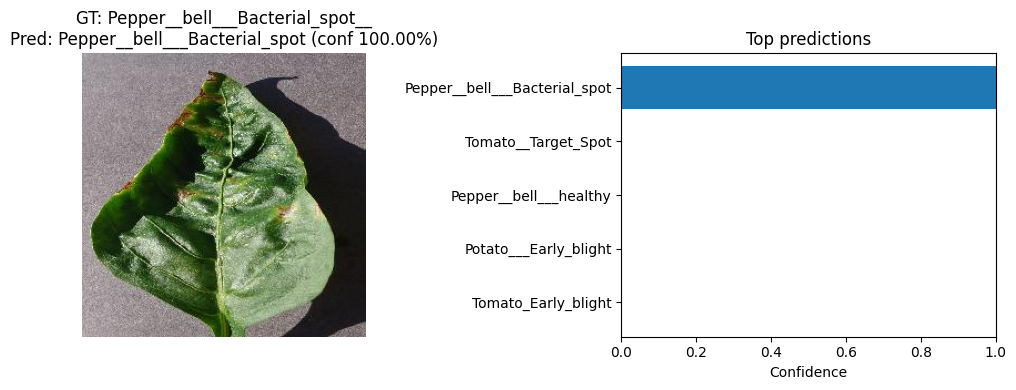

=== Pepper__bell___Bacterial_spot__0719e8e8-c1ae-4d5a-b29c-dbadc36d13f3___NREC_B.Spot 1947.JPG ===


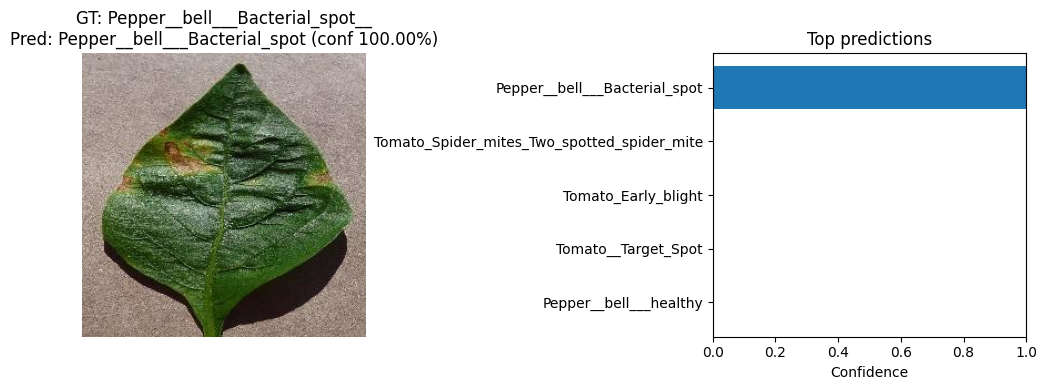

=== Pepper__bell___Bacterial_spot__080b107a-192f-40ce-8942-d8ccca8dfc52___NREC_B.Spot 1872.JPG ===


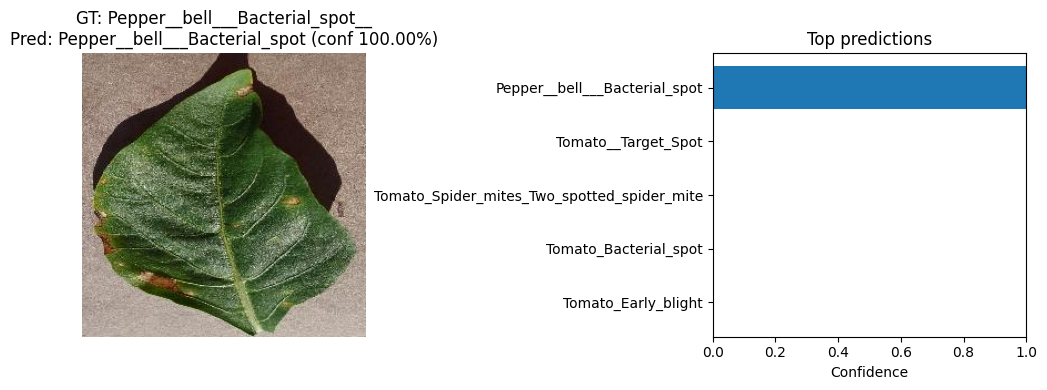

=== Pepper__bell___healthy__002f87b7-e1a5-49e5-a422-bb423630ded5___JR_HL 8068.JPG ===


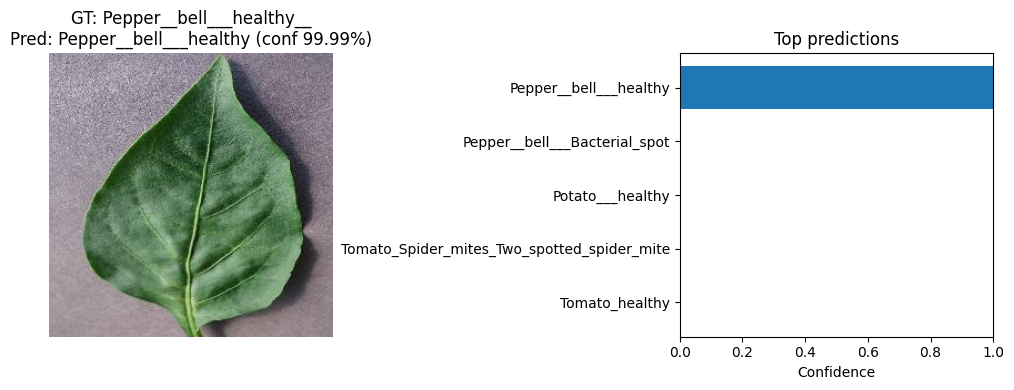

=== Pepper__bell___healthy__0137d804-551d-4f78-88b4-d603056dd7e7___JR_HL 7719.JPG ===


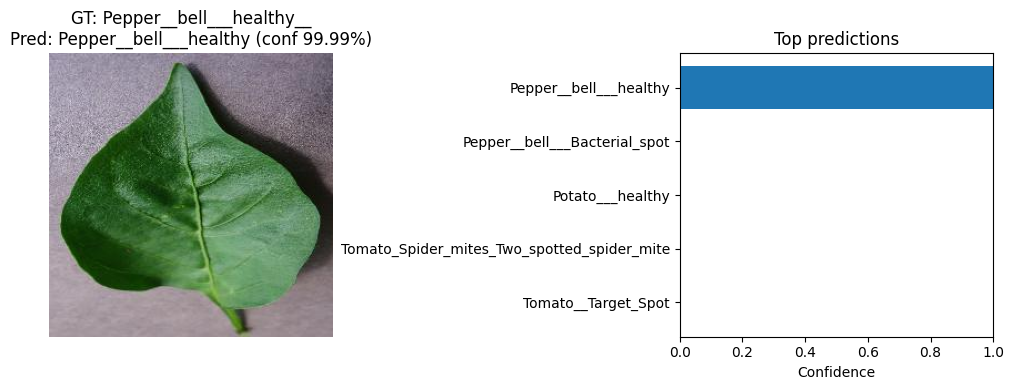

=== Pepper__bell___healthy__03c966a7-ac9e-4c8e-965a-6c0e7289a0e8___JR_HL 8509.JPG ===


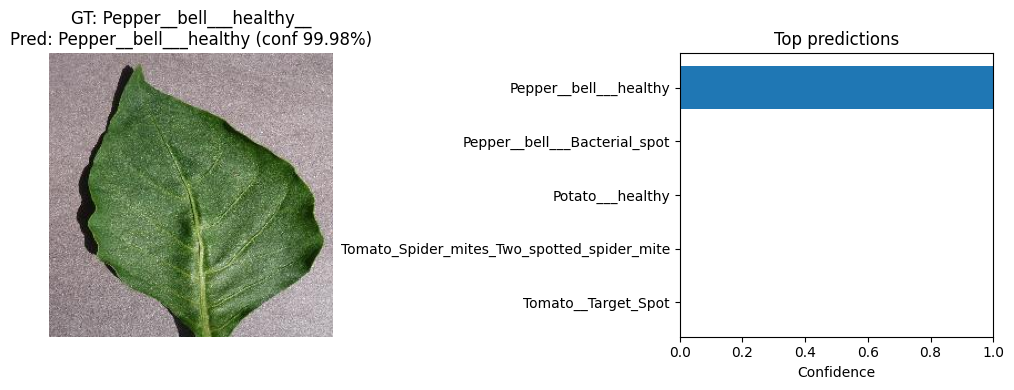

=== Potato___Early_blight__02578b86-b234-4ac0-9bc3-691b5610e2bf___RS_Early.B 7562.JPG ===


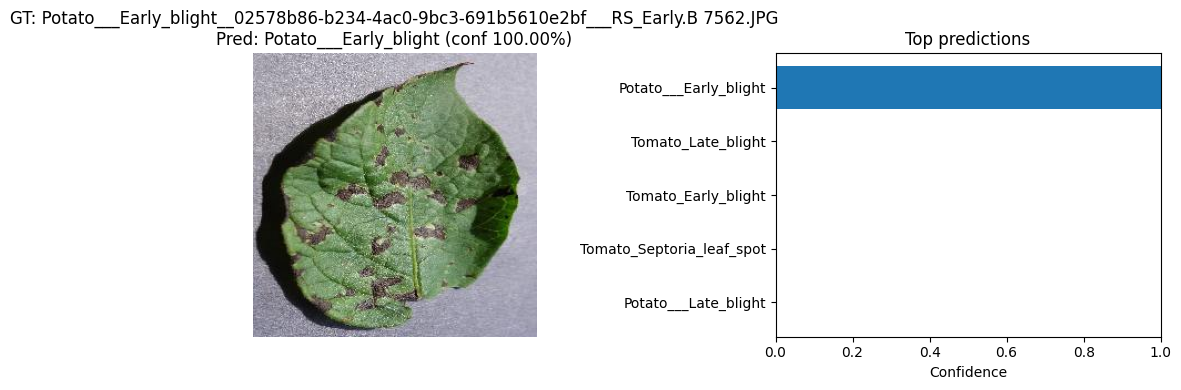

=== Potato___Early_blight__0267d4ca-522e-4ca0-b1a2-ce925e5b54a2___RS_Early.B 7020.JPG ===


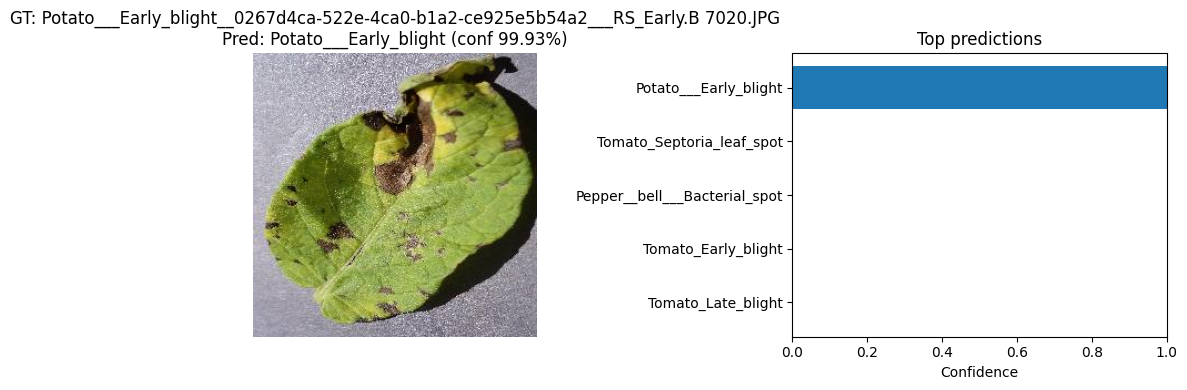

=== Potato___Early_blight__03b0d3c1-b5b0-48f4-98aa-f8904670290f___RS_Early.B 7051.JPG ===


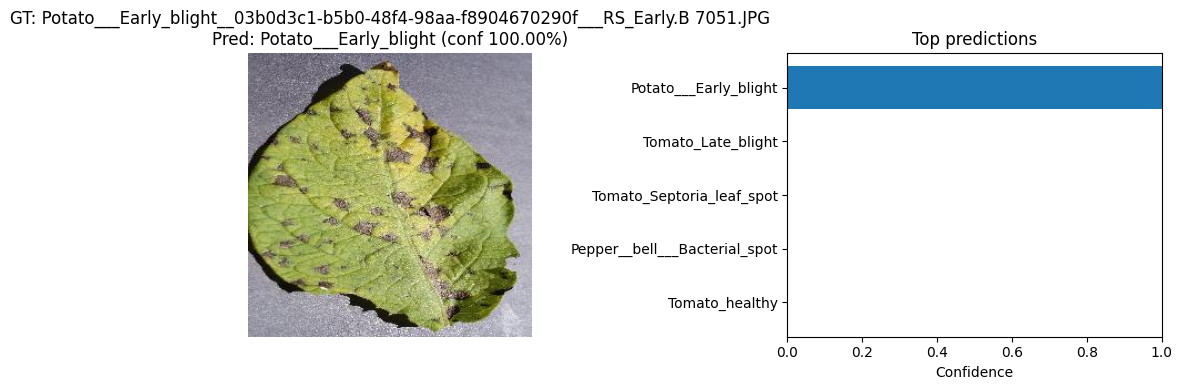

=== Potato___Late_blight__0051e5e8-d1c4-4a84-bf3a-a426cdad6285___RS_LB 4640.JPG ===


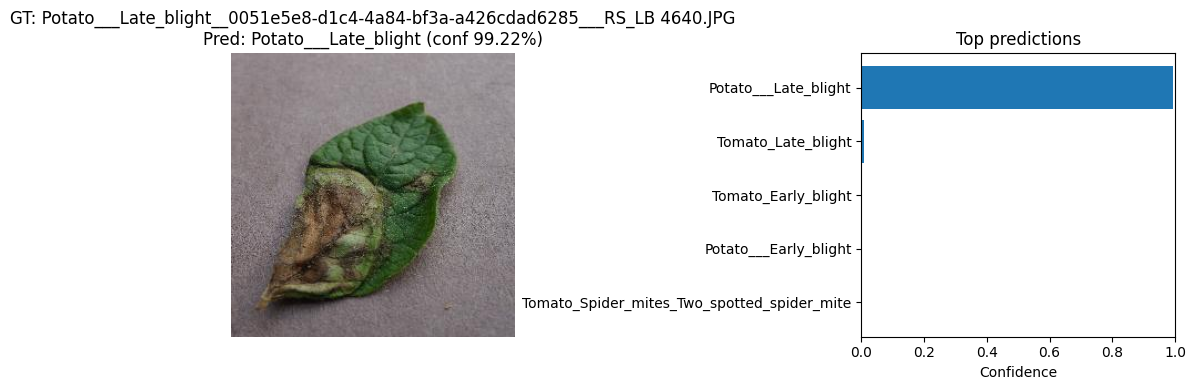

In [7]:
NUM_IMAGES = 10
results = []
for image_path in image_candidates[:NUM_IMAGES]:
    print(f'=== {image_path.name} ===')
    pred = show_prediction(image_path, topk=5)
    results.append(pred)